In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# google sentencepiece 설치
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.8 MB/s eta 0:00:00


In [3]:
##### pytorch #####
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset


##### 시각화 #####
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns 

##### 기본 모듈 #####
import pandas as pd
import numpy as np
import os
import random
import json
import math
import easydict
from pprint import pprint
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

##### 디버깅 #####
import pdb

##### cuda #####
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # GPU 할당

##### 경고무시 #####
import warnings
warnings.filterwarnings(action='ignore')

import sentencepiece as spm

In [4]:
vocab_file = "/content/drive/MyDrive/2.Study/GPT/Data/kowiki.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

True

In [5]:
config = easydict.EasyDict({
    "n_dec_vocab": len(vocab),
    "n_dec_seq": 256,
    "n_layer": 6,
    "d_hidn": 256,
    "i_pad": 0,
    "d_ff": 1024,
    "n_head": 4,
    "d_head": 64,
    "dropout": 0.1,
    "layer_norm_epsilon": 1e-12
                })

---
# Multi-head Attention
---

- 주로 텍스트의 문맥 정보를 파악하기 위한 목적으로 사용

- 입력된 문장을 여러개의 헤드로 나누고, 각 헤드가 문맥 정보를 학습

- 이후 여러개의 헤드의 출력값을 연결(concatenate)하여 최종 출력값을 만들게 된다.

- 위 과정을 통해 문장 내 단어들 사이의 의미론적 관계를 학습하고, 문장의 전체적인 의미를 파악할 수 있게 된다.

- 현재 생성하려는 단어와 이전 단어들간의 의미론적 관계를 파악하여 다음 단어를 예측


In [6]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.config = config

        self.W_Q = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.W_K = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.W_V = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        '''입력으로 들어온 차원(d_hidn)을 
           헤드의 개수(n_head)와 헤드의 차원(d_head)으로 나누어 가중치 행렬을 생성 '''
           
        self.scaled_dot_attn = ScaledDotProductAttention(self.config)
        self.linear = nn.Linear(self.config.n_head * self.config.d_head, self.config.d_hidn)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)
        
        q_s = self.W_Q(Q).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2) # (bs, n_head, q_seq_len, d_head)
        
        k_s = self.W_K(K).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2) # (bs, n_head, k_seq_len, d_head)
        
        v_s = self.W_V(V).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2) # (bs, n_head, v_seq_len, d_head)

        
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.config.n_head, 1, 1) # (bs, n_head, q_seq_len, k_seq_len)

        
        context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask)
        '''context = Attention score를 기반으로 하는 v_s의 가중 합 (bs, n_head, q_seq_len, d_head)
           attn_prob = 시퀀스에 대한 Attention Distribution (bs, n_head, q_seq_len, k_seq_len)'''
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.config.n_head * self.config.d_head) # (bs, n_head, q_seq_len, h_head * d_head)
        
        output = self.linear(context) # (bs, n_head, q_seq_len, e_embd)
        output = self.dropout(output)

        return output, attn_prob # (bs, q_seq_len, d_hidn), (bs, n_head, q_seq_len, k_seq_len)

---
# Scaleed Dot Product Attention
----

- Query, Key, Value 3가지 벡터를 사용하여 주어진 문장을 이해하는데 사용

- Query 
  - 각 단어가 다른 단어들과 어떤 관계를 맺고 있는지 나타내는 행렬

  - 행렬을 구성하기 위해, 입력 seq의 각 단어의 임베딩 벡터를 입력으로 받고  
    이를 선형 변환한 결과를 다시 하나의 벡터로 변환

  - 이 벡터는 각 단어의 의미적인 정보를 담고 있는 행렬의 열로 사용된다.

- Key 

  - 각 단어가 다른 단어들과 어떤 유사성을 가지고 있는지를 나타내는 행렬

- Value 

  - 입력 seq의 각 단어에 대한 정보를 나태나는 행렬

  - value 값은 Multi-head Attetntion에서 각 당너의 임베딩 벡터를 매핑하는데 사용


Query값과 Key값의 내적 결과를 Softmax함수를 통해 정규화하여 각 단어에 대한 가중치를 구하고

가중치를 이용해 value값을 Weighted Sum하여 Attention Context Vector를 계산

이를 통해 입력 seq에서 각 단어에 대한 정보를 인코딩하는데 사용

주어진 Query에 대해 가장 관련성이 높은 key-value 쌍을 선택하여 이를 통해 다음 단어를 예측하거나 문장을 생성

In [7]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.dropout = nn.Dropout(config.dropout)
        self.scale = 1 / (self.config.d_head ** 0.5)
    
    def forward(self, Q, K, V, attn_mask):
        
        scores = torch.matmul(Q, K.transpose(-1, -2)) # (bs, n_head, n_q_seq, n_k_seq)
        scores = scores.mul_(self.scale)
        scores.masked_fill_(attn_mask, -1e9)
        
        attn_prob = nn.Softmax(dim=-1)(scores) # (bs, n_head, n_q_seq, n_k_seq)
        attn_prob = self.dropout(attn_prob)
        
        context = torch.matmul(attn_prob, V) # (bs, n_head, n_q_seq, d_v)
        
        # (bs, n_head, n_q_seq, d_v), (bs, n_head, n_q_seq, n_v_seq)
        return context, attn_prob

---
# Position-wise Feed Forward Net
---

In [8]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.conv1 = nn.Conv1d(in_channels=self.config.d_hidn, out_channels=self.config.d_hidn * 4, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=self.config.d_hidn * 4, out_channels=self.config.d_hidn, kernel_size=1)
        self.active = F.gelu # 비선형성을 추가하고 모델의 표현력을 증가
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, inputs):
        
        output = self.active(self.conv1(inputs.transpose(1, 2))) # (bs, d_ff, n_seq)
        
        output = self.conv2(output).transpose(1, 2) # (bs, n_seq, d_hidn)
        output = self.dropout(output)
        return output # (bs, n_seq, d_hidn)

---
# ETC
---

In [9]:
# Position Encoding값을 구하는 함수 

def get_sinusoid_encoding_table(n_seq, d_hidn):
    
    # 입력 위치와 임베딩 차원에 따라 해당 위치의 각도값을 계산
    def cal_angle(position, i_hidn):
        return position / np.power(10000, 2 * (i_hidn // 2) / d_hidn)
    
    # 입력 위치에 따라 모든 임베딩 차원의 각도값 계산 
    def get_posi_angle_vec(position):
        return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]

    # seq길이와 임베딩 차원 수에 따라 시퀀스 길이 만큼 반복해서 생성된 값들을 저장
    sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)])
    
    # 짝수 인덱스의 값들은 sin함수로 계산하고 홀수는 cos함수로 계산
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # even index sin 
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # odd index cos
    '''sin, cos 함수는 시계열, 주기성이 있는 데이처를 처리할 때 사용되며 
       생성된 값들은 특정한 주기를 가지게 되며 이를 통해 입력 seq내의 토큰 위치를 구분할 수 있게 됨
       
       즉, sin, cos를 사용해 위치 정보를 부여함으로써 
       입력 seq 토큰 위치에 대한 정보를 학습하고 이를 활용해 문맥 정보를 파악할 수 있게 됨'''
    return sinusoid_table

<img src='https://paul-hyun.github.io/assets/2019-12-19/pad_mask.png'>

In [10]:
# padding이 적용된 위치에 대한 mask를 생성하는 함수 
def get_attn_pad_mask(seq_q, seq_k, i_pad):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()

    # i_pad와 일치하는 부분을 True, 아니면 False
    pad_attn_mask = seq_k.data.eq(i_pad)

    # seq_k와 같은 길이로 len_q까지 확장
    pad_attn_mask= pad_attn_mask.unsqueeze(1).expand(batch_size, len_q, len_k)
    return pad_attn_mask

<img src='https://paul-hyun.github.io/assets/2019-12-19/decoder_mask.png'>

In [11]:
# attention decoder mask 
def get_attn_decoder_mask(seq):

    # Decoder의 입력 시퀀스와 동일한 크기의 tensor를 생성하고 모든 요소를 1로 채움
    subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1))
    
    # 대각선 기준 위쪽 삼각형만 남기고 아래쪽 삼각형을 0으로 만듬
    subsequent_mask = subsequent_mask.triu(diagonal=1) # upper triangular part of a matrix(2-D)
    
    # Decoder의 입력 시퀀스를 대각선 기준으로 위쪽 삼각형 = 0, 아래쪽 삼각형 = 1로 채운 이진 행렬 
    return subsequent_mask

----
# Decoder Layer
----

<img src='https://paul-hyun.github.io/assets/2019-12-30/decoder.png'>

In [12]:
class DecoderLayer(nn.Module):
  
  def __init__(self, config):
    super().__init__()
    self.config = config

    self.self_attn = MultiHeadAttention(self.config)
    self.layer_norm1 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
    '''입력 tensor의 마지막 차원을 기준으로 계산된 평균과 표준편차를 이용하여 정규화된 tensor를 출력
       학습 안정화 / Gradient vanishing / 일반화 성능향상에 장점이존재'''
       
    self.pos_ffn = PoswiseFeedForwardNet(self.config)
    self.layer_norm3 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
  
  def forward(self, dec_inputs, self_attn_mask):
      
    self_att_outputs, self_attn_prob = self.self_attn(dec_inputs, dec_inputs, dec_inputs, self_attn_mask)
    # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_dec_seq)

    self_att_outputs = self.layer_norm1(dec_inputs + self_att_outputs)
    
    
    ffn_outputs = self.pos_ffn(self_att_outputs) # (bs, n_dec_seq, d_hidn)
    ffn_outputs = self.layer_norm3(self_att_outputs + ffn_outputs)
    
    return ffn_outputs, self_attn_prob    
    # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_dec_seq), (bs, n_head, n_dec_seq, n_enc_seq)

---
# Decoder
---

In [13]:
class Decoder(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config

    self.dec_emb = nn.Embedding(self.config.n_dec_vocab, self.config.d_hidn)
    sinusoid_table = torch.FloatTensor(get_sinusoid_encoding_table(self.config.n_dec_seq + 1, self.config.d_hidn))
    self.pos_emb = nn.Embedding.from_pretrained(sinusoid_table, freeze=True)

    # n_layer 개수 만큼 Decoder 생성 
    self.layers = nn.ModuleList([DecoderLayer(self.config) for _ in range(self.config.n_layer)])
  
  def forward(self, dec_inputs):

    # input값의 각 위치에 대한 position을 저장하는 Tensor
    positions = torch.arange(dec_inputs.size(1), device=dec_inputs.device, dtype=dec_inputs.dtype).expand(dec_inputs.size(0), dec_inputs.size(1)).contiguous() + 1
    # 패딩 부분을 True로
    pos_mask = dec_inputs.eq(self.config.i_pad)
    positions.masked_fill_(pos_mask, 0)

    # 각 단어의 임베딩 벡터와 position값을 더한 값 계산
    dec_outputs = self.dec_emb(dec_inputs) + self.pos_emb(positions) # (bs, n_dec_seq, d_hidn)


    dec_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs, self.config.i_pad) # (bs, n_dec_seq, n_dec_seq)
    dec_attn_decoder_mask = get_attn_decoder_mask(dec_inputs)                        # (bs, n_dec_seq, n_dec_seq)
    dec_self_attn_mask = torch.gt((dec_attn_pad_mask + dec_attn_decoder_mask), 0)    # (bs, n_dec_seq, n_dec_seq)

    self_attn_probs = []
    for layer in self.layers:
        # (bs, n_dec_seq, d_hidn), (bs, n_dec_seq, n_dec_seq)
        dec_outputs, self_attn_prob = layer(dec_outputs, dec_self_attn_mask)
        self_attn_probs.append(self_attn_prob)
    
    # (bs, n_dec_seq, d_hidn), [(bs, n_dec_seq, n_dec_seq)]
    return dec_outputs, self_attn_probs

---
# GPT-1
---

In [14]:
class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.decoder = Decoder(self.config)
    
    def forward(self, dec_inputs):
        # (bs, n_seq, d_hidn), [(bs, n_head, n_dec_seq, n_dec_seq)]
        dec_outputs, dec_self_attn_probs = self.decoder(dec_inputs)
        # (bs, n_dec_seq, n_dec_vocab), [(bs, n_head, n_dec_seq, n_dec_seq)]
        return dec_outputs, dec_self_attn_probs
    
    def save(self, epoch, loss, path):
        torch.save({
            "epoch": epoch,
            "loss": loss,
            "state_dict": self.state_dict()
        }, path)
    
    def load(self, path):
        save = torch.load(path)
        self.load_state_dict(save["state_dict"])
        return save["epoch"], save["loss"]

---
# Pretrain
---

In [15]:
# 입력 단어에 대한 다음 단어를 예측이 목적

class GPTPretrain(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.gpt = GPT(self.config)
        
        # GPT의 결과를 입력으로 단어를 예측하기 위한 코드
        self.projection_lm = nn.Linear(self.config.d_hidn, self.config.n_dec_vocab, bias=False)
        # 가중치를 GPT 모델의 Decoder의 임베딩 가중치로 설정
        self.projection_lm.weight = self.gpt.decoder.dec_emb.weight
    
    def forward(self, dec_inputs):
        
        dec_outputs, dec_self_attn_probs = self.gpt(dec_inputs) # (bs, n_dec_seq, d_hidn), [(bs, n_head, n_dec_seq, n_dec_seq)]
        
        # LM의 예측값
        logits_lm = self.projection_lm(dec_outputs) # (bs, n_dec_seq, n_dec_vocab)
        
        # (bs, n_dec_seq - 1, n_dec_vocab), (bs, n_output), [(bs, n_head, n_dec_seq, n_dec_seq)]
        return logits_lm[:, :-1, :].contiguous(), dec_self_attn_probs
        '''예측값의 마지막 토큰인 [EOS]는 학습시킬 필요가 없기 때문에 맨 마지막 토큰을 제외하고 return
           
           메모리 사용량을 줄이기 위해 contiguous() 함수를 사용'''

---
# Pretrain Data
---

In [16]:
def create_pretrain_instances(doc, n_seq):

    # [BOS] [EOS]를 뺀 값
    tgt_seq = n_seq - 2
    
    instances = []
    # max_seq 이하의 길이를 가지는 문장을 저장
    current_chunk = []
    # current_chunk에 추가된 문장들의 총 길이
    current_length = 0
    for i in range(len(doc)):
        current_chunk.append(doc[i])
        current_length += len(doc[i])
        # 마지막 줄이거나 current_length가 tgt_seq를 넘을 경우 학습 데이터 생성 
        if i == len(doc) - 1 or current_length >= tgt_seq:
            if 0 < len(current_chunk):
                tokens = []
                for chunk in current_chunk: tokens.extend(chunk)
                tokens = tokens[:tgt_seq]
                if 1 < len(tokens):
                    instance = {
                        "tokens": ["[BOS]"] + tokens + ["[EOS]"],
                    }
                    instances.append(instance)
            current_chunk = []
            current_length = 0
    return instances

In [17]:
def make_pretrain_data(vocab, in_file, out_file, n_seq):
    line_cnt = 0
    with open(in_file, "r") as in_f:
        for line in in_f:
            line_cnt += 1

    docs = []
    with open(in_file, "r") as f:
        doc = []
        with tqdm(total=line_cnt, desc=f"Loading") as pbar:
            for i, line in enumerate(f):
                line = line.strip()
                if line == "":
                    if 0 < len(doc):
                        docs.append(doc)
                        doc = []
                else:
                    pieces = vocab.encode_as_pieces(line)
                    if 0 < len(pieces):
                        doc.append(pieces)
                pbar.update(1)
        if doc:
            docs.append(doc)

    with open(out_file, "w") as out_f:
        with tqdm(total=len(docs), desc=f"Making") as pbar:
            for i, doc in enumerate(docs):
                instances = create_pretrain_instances(doc, n_seq)
                for instance in instances:
                    out_f.write(json.dumps(instance))
                    out_f.write("\n")
                pbar.update(1)

In [18]:
in_file = "/content/drive/MyDrive/2.Study/GPT/Data/kowiki.txt"
out_file = "/content/drive/MyDrive/2.Study/GPT/Data/kowiki_gpt.json"
n_seq = 256

if not os.path.isfile(out_file):
    make_pretrain_data(vocab, in_file, out_file, n_seq)
else:
    print(f"{out_file} exists")

/content/drive/MyDrive/2.Study/GPT/Data/kowiki_gpt.json exists


---
# Dataset
---

In [19]:
class PretrainDataSet(torch.utils.data.Dataset):
    def __init__(self, vocab, infile):
        self.vocab = vocab
        self.sentences = []

        line_cnt = 0
        with open(infile, "r") as f:
            for line in f:
                line_cnt += 1

        with open(infile, "r") as f:
            for i, line in enumerate(tqdm(f, total=line_cnt, desc="Make Pretrain Dataset", unit=" lines")):
                instance = json.loads(line)
                self.sentences.append([vocab.piece_to_id(p) for p in instance["tokens"]])
    
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, item):
        return (torch.tensor(self.sentences[item]), torch.tensor(item))

def pretrin_collate_fn(inputs):
    
    dec_inputs, item = list(zip(*inputs))
    '''리스트의 각 원소들에서 같은 인덱스에 해당하는 값을 묶어 
       튜플로 만든 다음 이를 하나의 리스트로 묶은 형태
       [(1,2), (3,4), (5,6)] ->[(1,3,5), (2,4,6)] 형태로 반환'''

    # 패딩 처리
    dec_inputs = torch.nn.utils.rnn.pad_sequence(dec_inputs, batch_first=True, padding_value=0)

    batch = [
        dec_inputs,
        torch.stack(item, dim=0)]
    '''item = 각 입력 샘플의 인덱스를 나타내는 scalar 값들의 리스트
        인덱스 값들을 모두 하나의 tensor로 묶어서 batch내의 
        각 샘플에 대한 정보를 전달하기 위해서 stack을 사용해 하나의 tensor로 결합을 해준다.
        
        후처리 단계에서 batch내의 각 샘플에 대한 정보를 더 쉽게 추출할수 있게 된다.'''
    return batch        

---
# DataLoader
---

In [20]:
batch_size = 128
dataset = PretrainDataSet(vocab, "/content/drive/MyDrive/2.Study/GPT/Data/kowiki_gpt.json")
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=pretrin_collate_fn)

Make Pretrain Dataset:   0%|          | 0/1022815 [00:00<?, ? lines/s]

---
# Pretrain Model Train
----

In [21]:
def train_epoch(config, epoch, model, criterion_lm, optimizer, train_loader):
    losses = []
    model.train()

    with tqdm(total=len(train_loader), desc=f"Train({epoch})") as pbar:
        for i, value in enumerate(train_loader):
            dec_inputs, _ = map(lambda v: v.to(device), value)
            labels_lm = dec_inputs[:, 1:].contiguous()

            optimizer.zero_grad()
            outputs = model(dec_inputs)
            logits_lm = outputs[0]

            loss_lm = criterion_lm(logits_lm.view(-1, logits_lm.size(2)), labels_lm.view(-1))
            loss = loss_lm 

            loss_val = loss_lm.item()
            losses.append(loss_val)

            loss.backward()
            optimizer.step()

            pbar.update(1)
            pbar.set_postfix_str(f"Loss: {loss_val:.3f} ({np.mean(losses):.3f})")
    return np.mean(losses)

In [22]:
learning_rate = 5e-5
n_epoch = 20

In [23]:
pprint(config)

{'d_ff': 1024,
 'd_head': 64,
 'd_hidn': 256,
 'dropout': 0.1,
 'i_pad': 0,
 'layer_norm_epsilon': 1e-12,
 'n_dec_seq': 256,
 'n_dec_vocab': 8007,
 'n_head': 4,
 'n_layer': 6}


In [24]:
model = GPTPretrain(config)

save_pretrain = "/content/drive/MyDrive/2.Study/GPT/Data/save_gpt_pretrain.json"
best_epoch, best_loss = 0, 0
if os.path.isfile(save_pretrain):
    best_epoch, best_loss = model.gpt.load(save_pretrain)
    print(f"load pretrain from: {save_pretrain}, epoch={best_epoch}, loss={best_loss}")
    best_epoch += 1

model.to(device)

criterion_lm = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses = []
offset = best_epoch
for step in tqdm(range(n_epoch)):
    epoch = step + offset
    loss = train_epoch(config, epoch, model, criterion_lm, optimizer, train_loader)
    losses.append(loss)
    model.gpt.save(epoch, loss, save_pretrain)

load pretrain from: /content/drive/MyDrive/2.Study/GPT/Data/save_gpt_pretrain.json, epoch=2, loss=3.7503775782018858


  0%|          | 0/20 [00:00<?, ?it/s]

Train(3):   0%|          | 0/7991 [00:00<?, ?it/s]

Train(4):   0%|          | 0/7991 [00:00<?, ?it/s]

Train(5):   0%|          | 0/7991 [00:00<?, ?it/s]

Train(6):   0%|          | 0/7991 [00:00<?, ?it/s]

Train(7):   0%|          | 0/7991 [00:00<?, ?it/s]

Train(8):   0%|          | 0/7991 [00:00<?, ?it/s]

Train(9):   0%|          | 0/7991 [00:00<?, ?it/s]

Train(10):   0%|          | 0/7991 [00:00<?, ?it/s]

Train(11):   0%|          | 0/7991 [00:00<?, ?it/s]

Train(12):   0%|          | 0/7991 [00:00<?, ?it/s]

Train(13):   0%|          | 0/7991 [00:00<?, ?it/s]

Train(14):   0%|          | 0/7991 [00:00<?, ?it/s]

Train(15):   0%|          | 0/7991 [00:00<?, ?it/s]

Train(16):   0%|          | 0/7991 [00:00<?, ?it/s]

Train(17):   0%|          | 0/7991 [00:00<?, ?it/s]

Train(18):   0%|          | 0/7991 [00:00<?, ?it/s]

Train(19):   0%|          | 0/7991 [00:00<?, ?it/s]

Train(20):   0%|          | 0/7991 [00:00<?, ?it/s]

Train(21):   0%|          | 0/7991 [00:00<?, ?it/s]

Train(22):   0%|          | 0/7991 [00:00<?, ?it/s]

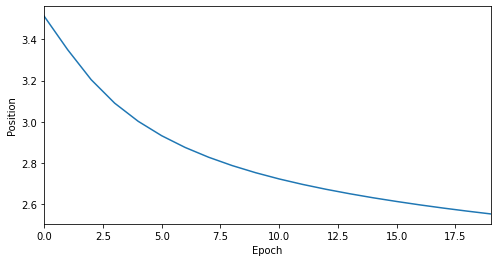

In [27]:
data = {
    "loss": losses
}
df = pd.DataFrame(data)

# graph
plt.figure(figsize=[8, 4])
plt.plot(losses)
plt.xlabel('Epoch')
plt.xlim((0, n_epoch - 1))
plt.ylabel('Position')
plt.show()